### Imports
- Data like stopword, tokenizers and stemmers from ntlk is required. 
```
>>>import nltk
>>>nltk.download('all')
```

In [1]:
import pandas
import numpy
import scipy
import sys
import re
import string
import csv
import emoji
import matplotlib.pyplot as plt
import time
import seaborn as sn
import sklearn.metrics

from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud

from sklearn import svm
from sklearn import tree
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV

### Pre-processing function

In [2]:
def string_preprocess(text_string,
               rm_stopwords = True,
               sub_emoji = True,
               rm_ponctuation = True,
               rm_digits = True,
               add_stemmer = True):

    text_string = word_tokenize(text_string)
    
    # Removes Stop Words
    if rm_stopwords:
        stop_words = set(stopwords.words('english'))
        text_string = [word for word in text_string if word not in stop_words]
    
    # Replace Emojis with 'EMOJI'
    if sub_emoji:
        text_string = [emoji.get_emoji_regexp().sub('EMOJI ', word) for word in text_string]
        
    # Removes digits (0 - 9)
    if rm_digits:
        text_string = [word for word in text_string if not word.isdigit()]
    
    # Use the Porter Stemmer on the words
    if add_stemmer:
        ps = PorterStemmer()
        text_string = [ps.stem(word) for word in text_string]
        
    # Removes ponctuation
    if rm_ponctuation:
        table = str.maketrans('', '', string.punctuation)
        text_string = [word.translate(table) for word in text_string]
        
    # Additional formating
    mention_regex = '@[\w\-]+'
    text_string = [re.sub(mention_regex, 'MENTIONHERE', word) for word in text_string]
    
    text_string = [word for word in text_string if word != '' and word.isalnum()]
 

    return ' '.join(text_string)

### Pre-processing
- Recives a pandas dataframe with the colum name and pre-process the string

In [3]:
def pre_process(text_data, column_name):
    for linha in range(len(text_data)):
        text = text_data.at[linha, column_name]
        text = string_preprocess(text)
        text_data.at[linha, column_name] = text

### Getting the corpus
- Recives X dataframes and returns a list of all words of a column

In [4]:
def get_corpus(column, *args):
    full_corpus = []
    
    for text_dataframe in args:
        for linha in range(len(text_dataframe)):
            full_corpus.append(text_dataframe.at[linha, column])
    
    return full_corpus

### BOW creating function

In [5]:
def get_bow(corpus):
    vectorizer = CountVectorizer(encoding = 'unicode',
                             strip_accents = 'unicode',
                             ngram_range = (1,3),
                             analyzer = 'word',
                             max_df = 0.95, 
                             binary = True)
    
    return vectorizer.fit_transform(corpus)

### Confusion matrix plot

In [6]:
def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(4, 3))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

### Grid search function

In [7]:
def svc_param_selection(X, y, nfolds):
    Cs = [0.001, 0.01, 0.1, 1, 10]
    gammas = [0.001, 0.01, 0.1, 1]
    param_grid = {'C': Cs, 'gamma' : gammas}
    grid_search = GridSearchCV(svm.SVC(kernel='linear'), param_grid, cv=nfolds, n_jobs=-1)
    grid_search.fit(X, y)
    grid_search.best_params_
    return grid_search.best_params_

### Getting and preprocessing the tweets

In [8]:
training_tsv = pandas.read_csv('offenseval-training-v1.tsv', sep='\t')

#print(training_tsv)

training_tsv = training_tsv[training_tsv.subtask_b == 'TIN']
#print(training_tsv)
training_tsv = training_tsv.reset_index(drop=True)

complete_corpus = get_corpus('tweet', training_tsv)
corpus_bow = get_bow(complete_corpus)

complete_labels = [training_tsv.at[linha, "subtask_c"] for linha in range(len(training_tsv))]

In [9]:
cVals = [0.001, 0.10, 0.1, 10, 25, 50, 100, 1000]
gammaVals = [1e-2, 1e-3, 1e-4, 1e-5]

tuned_parameters = [{'kernel': ['rbf'], 'gamma': gammaVals, 'C': cVals },
                     {'kernel': ['sigmoid'], 'gamma': gammaVals, 'C': cVals},
                     {'kernel': ['linear'], 'C': cVals}
                   ]

scores = ['f1']

for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(SVC(C=1), tuned_parameters, cv=10,
                       scoring='%s_macro' % score, n_jobs=-1)
    clf.fit(corpus_bow, complete_labels)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()
    
# 0.496 (+/-0.054) for {'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}
# 0.493 (+/-0.052) for {'C': 1000, 'gamma': 0.001, 'kernel': 'sigmoid'}
# 0.494 (+/-0.056) for {'C': 10, 'kernel': 'linear'}

# Tuning hyper-parameters for f1

Best parameters set found on development set:

{'C': 1000, 'gamma': 0.001, 'kernel': 'rbf'}

Grid scores on development set:

0.255 (+/-0.001) for {'C': 0.001, 'gamma': 0.01, 'kernel': 'rbf'}
0.255 (+/-0.001) for {'C': 0.001, 'gamma': 0.001, 'kernel': 'rbf'}
0.255 (+/-0.001) for {'C': 0.001, 'gamma': 0.0001, 'kernel': 'rbf'}
0.255 (+/-0.001) for {'C': 0.001, 'gamma': 1e-05, 'kernel': 'rbf'}
0.255 (+/-0.001) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.255 (+/-0.001) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.255 (+/-0.001) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.255 (+/-0.001) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.255 (+/-0.001) for {'C': 0.1, 'gamma': 0.01, 'kernel': 'rbf'}
0.255 (+/-0.001) for {'C': 0.1, 'gamma': 0.001, 'kernel': 'rbf'}
0.255 (+/-0.001) for {'C': 0.1, 'gamma': 0.0001, 'kernel': 'rbf'}
0.255 (+/-0.001) for {'C': 0.1, 'gamma': 1e-05, 'kernel': 'rbf'}
0.469 (+/-0.036) for {'C': 10, 'gamma': 0.01, 'kerne

In [11]:
f1_score = []
precision_score = []
recall_score = []
accuracy_score = []
cm = []

classifier = svm.SVC(C=1000, kernel='rbf', gamma=0.001)

#-----
start = time.time()
#-----

skf = StratifiedKFold(n_splits=10)

for training_index, test_index in skf.split(corpus_bow, complete_labels):
    training_bow = corpus_bow[training_index]
    analysis_bow = corpus_bow[test_index]
    
    training_labels = [complete_labels[i] for i in training_index]
    analysis_labels = [complete_labels[i] for i in test_index]

    classifier.fit(training_bow, training_labels)

    prediction = classifier.predict(analysis_bow)
    
    f1_score.append(metrics.f1_score(analysis_labels, prediction, average=None))
    precision_score.append(metrics.precision_score(analysis_labels, prediction, average=None))
    recall_score.append(metrics.recall_score(analysis_labels, prediction, average=None))
    accuracy_score.append((metrics.accuracy_score(analysis_labels, prediction)))
    cm.append(metrics.confusion_matrix(analysis_labels, prediction))
    
#-----
end = time.time()
#-----

F1 Score median:
0    0.592593
1    0.812065
2    0.086957

------------
Precision median:
0    0.594542
1    0.765152
2    0.309524

------------
Recall median:
0    0.574766
1    0.871369
2    0.050000

------------
Accuracy median:
0    0.706177

------------
Time taken:
50.0664803981781


<Figure size 432x288 with 0 Axes>

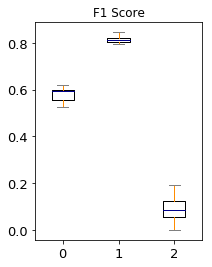

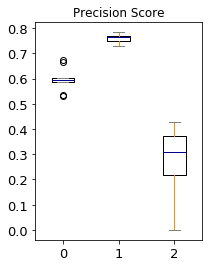

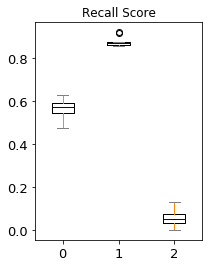

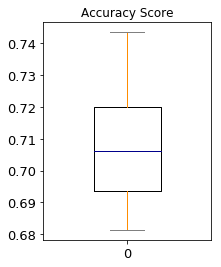

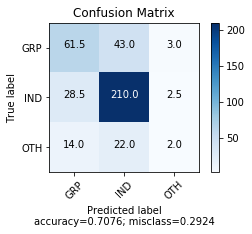

In [12]:
color = {'boxes': 'Black',
         'whiskers': 'DarkOrange',
         'medians': 'DarkBlue',
         'caps': 'Gray'}

f1_scores_df = pandas.DataFrame(f1_score)
plt.figure(num=4)
f1_scores_df.plot(color=color,
                  widths=0.4,
                  kind='box',
                  fontsize=13,
                  figsize=[3,4],
                  title='F1 Score')

print(f'F1 Score median:\n{f1_scores_df.median(axis=0).to_string()}\n')
#print(f'F1 Score max:\n{f1_scores_df.max(axis=0).to_string()}\n')
#print(f'F1 Score min:\n{f1_scores_df.min(axis=0).to_string()}\n')
print('------------')
#print(f1_plot)

precision_score_df = pandas.DataFrame(precision_score)
plt.figure(num=5)
precision_score_df.plot(color=color,
                        widths=0.4,
                        kind='box',
                        fontsize=13,
                        figsize=[3,4],
                        title='Precision Score')

print(f'Precision median:\n{precision_score_df.median(axis=0).to_string()}\n')
#print(f'Precision max:\n{precision_score_df.max(axis=0).to_string()}\n')
#print(f'Precision min:\n{precision_score_df.min(axis=0).to_string()}\n')
print('------------')
# print(precision_score)

recall_score_df = pandas.DataFrame(recall_score)
plt.figure(num=6)
recall_score_df.plot(color=color,
                     widths=0.4, kind='box',
                     fontsize=13,
                     figsize=[3,4],
                     title='Recall Score')

print(f'Recall median:\n{recall_score_df.median(axis=0).to_string()}\n')
#print(f'Recall max:\n{recall_score_df.max(axis=0).to_string()}\n')
#print(f'Recall min:\n{recall_score_df.min(axis=0).to_string()}\n')
print('------------')
# print(recall_score)

accuracy_score_df = pandas.DataFrame(accuracy_score)
plt.figure(num=7)
accuracy_score_df.plot(color=color,
                     widths=0.4, kind='box',
                     fontsize=13,
                     figsize=[3,4],
                     title='Accuracy Score')

print(f'Accuracy median:\n{accuracy_score_df.median(axis=0).to_string()}\n')
#print(f'Accuracy max:\n{accuracy_score_df.max(axis=0).to_string()}\n')
#print(f'Accuracy min:\n{accuracy_score_df.min(axis=0).to_string()}\n')
print('------------')
#print(accuracy_score)

print('Time taken:')
print(end - start)


cm_median = numpy.median(cm, axis=0)
plot_confusion_matrix(cm = cm_median, target_names = ["GRP", "IND", "OTH"], title = 'Confusion Matrix', normalize = False)